# Imports and Setup

In [16]:
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Image
from qutip import (Qobj, about, basis, coherent, coherent_dm, create, destroy,
                   expect, fock, fock_dm, mesolve, qeye, sigmax, sigmay,
                   sigmaz, tensor, thermal_dm, sesolve)
from scipy.optimize import curve_fit
%matplotlib widget
plt.rc('font', size=16)         # Set the default text font size
plt.rc('axes', titlesize=16)    # Set the axes title font size
plt.rc('axes', labelsize=16)    # Set the axes labels font size
plt.rc('xtick', labelsize=16)   # Set the font size for x tick labels
plt.rc('ytick', labelsize=16)   # Set the font size for y tick labels
plt.rc('legend', fontsize=18)   # Set the legend font size
plt.rc('figure', titlesize=20)  # Set the font size of the figure title
plt.rc("text", usetex=False)

#Adjusting the way to write some of the functions because I'm lazy
σx = sigmax
σy = sigmay
σz = sigmaz
I = qeye

# Hamiltonian
We will be using the Hamiltonian for a two level system in an electric field. Generically we write this as:
$$
\mathcal{H} = -(\epsilon + 2\vec{p}\cdot \vec{E}(t)\cos(t\phi) )\hat{S}^Z - 2\vec{p}\cdot \vec{E}(t)\sin (2\phi) \hat{S}^X
$$
Where we have $\epsilon = \sqrt{\Delta^2+\Delta_T^2}$ where $Delta$ is the energy asymmetry of the double well and $\Delta_T$ is the tunnelling probability between the two wells. $\phi$ defines the ratio between the all the energies in that $\tan 2\phi = \Delta_T/\Delta$, $\sin 2\phi = \Delta_T/\epsilon$, and $\cos 2\phi = \Delta/\epsilon$.

We will consider the case where we have two independent oscillating electric fields. This means that $\vec{E}(t)$ is given by $\vec{E}(t) = \vec{E}_1 \cos(\nu_1 t) + \vec{E}_2 \cos (\nu_2 t)$. This means that the full Hamiltonian is given by
$$
\mathcal{H}_2 = -\epsilon \hat{S}^Z - \sum_{i=1,2} 2\hbar \Omega_{Z,i}\cos(\nu_i t) \hat{S}^Z + 2\hbar \Omega_{X,,i}\cos(\nu_i t)\hat{S}^X
$$
where $\Omega_{z,i} = \Omega_0\cos(\theta_i)\cos(2\phi)$, $\Omega_{x.i}=\Omega\cos(\theta_i)\sin(2\phi)$ and $\Omega_0$ is the bare Rabi Frequency. $\theta_i$ is the angle between the electric dipole and the $\vec{E}_i$ field for each of teh two fields. We will consider the case that the $\Omega_{Z/X,1}=\Omega_{Z/X,2}\equiv \Omega_X$ so that we can rewrite the X component of the field to be:
$$
\Omega_{X,1}\cos(\nu_1 t) + \Omega_{X,2}\cos(\nu_2 t) = \Omega_x(\cos(\nu_1 t)+\cos(\nu_2 t)) = 2\Omega_x \cos(\tilde{\nu} t)\cos(\delta\nu t) \equiv \Omega_x(t)
$$
Where we defined $\tilde{\nu}=(\nu_1+\nu_2)/2$ and $\tilde{\nu_2} = (\nu_1-\nu_2)/2$. Then we can ignore the AC Stark term (the $\Omega_{Z,i}$ terms) and we apply the Rotating Wave Approximation we get the final Hamiltonian that we will use:

$$ \mathcal{H}'_2 = -(\epsilon - \hbar\tilde{\nu})\hat{S}^Z -2\hbar\Omega_X\cos(\delta\nu t)\hat{S}^X$$

## Define Hamiltonian

In [4]:
def H2(t: float, args: dict):

    ϵ = args["eps"]
    νp = args["vp"]
    Ωx = args["omegaX"]
    δν = args["dv"]
    return -(ϵ-νp)*Sz - 2*Ωx*np.cos(δν*t)*Sx

## Constants

In [53]:
δν = 0
νp = 5
Ωx = 0.1
ϵ = 5
Sx = σx()/2
Sy = σy()/2
Sz = σz()/2

## First Attempt Just Using the SE Solver

In [54]:
ψ0 = basis(2,0)
times = np.linspace(0,600,2500)
result = sesolve(H2,ψ0, times, e_ops=[], args=dict(eps=ϵ, vp=νp, omegaX=Ωx, dv=δν), progress_bar=True)

10.0%. Run time:   1.80s. Est. time left: 00:00:00:16
20.0%. Run time:   3.83s. Est. time left: 00:00:00:15
30.0%. Run time:   5.29s. Est. time left: 00:00:00:12
40.0%. Run time:   6.71s. Est. time left: 00:00:00:10
50.0%. Run time:   8.65s. Est. time left: 00:00:00:08
60.0%. Run time:  10.23s. Est. time left: 00:00:00:06
70.0%. Run time:  12.29s. Est. time left: 00:00:00:05
80.0%. Run time:  13.76s. Est. time left: 00:00:00:03
90.0%. Run time:  15.68s. Est. time left: 00:00:00:01
Total run time:  17.26s


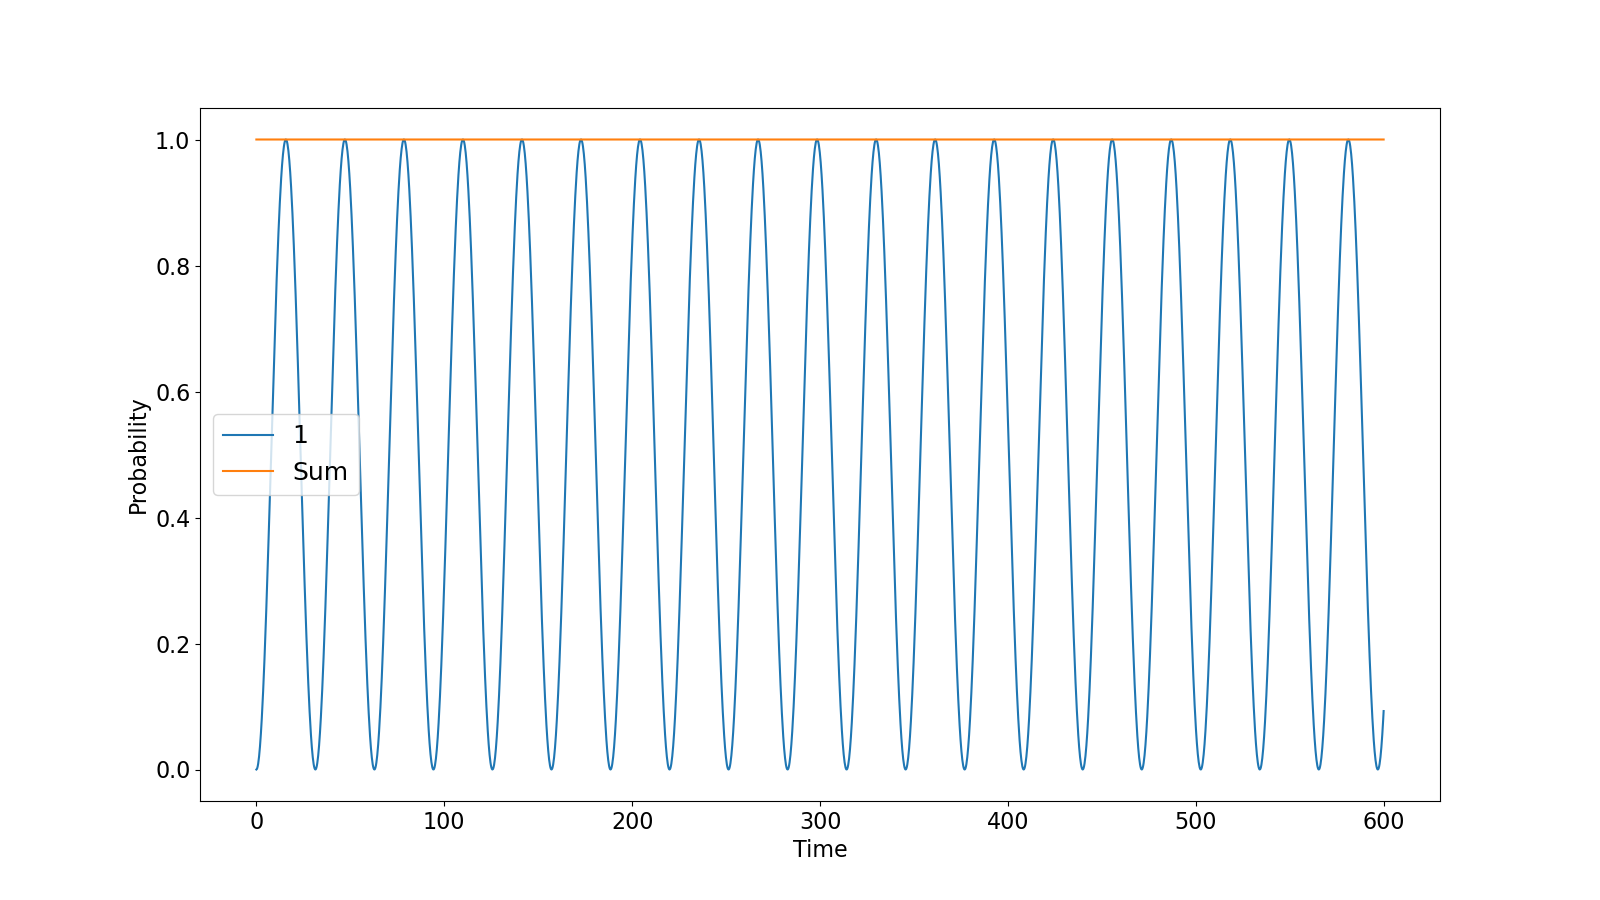

In [55]:
fig, ax = plt.subplots(figsize=(16,9))
probs = np.abs(result.states) ** 2
# ax.plot(result.times, probs[:,0], label="0")
ax.plot(result.times, probs[:,1], label="1")
ax.plot(result.times, probs[:,1]+probs[:,0], label="Sum")

ax.set_xlabel("Time")
ax.set_ylabel("Probability")
ax.legend()
plt.show()

In [40]:
def sineSqFit(t,A,v,ϕ, DC):
    return A*(np.sin(v*t+ϕ))**2+DC

In [56]:
pop, pcov = curve_fit(sineSqFit, result.times, probs[:,1].flatten(), [1, 0.1, 0, 0 ])
print(pop)

[9.99999617e-01 9.99995939e-02 5.74311779e-08 3.82167805e-07]


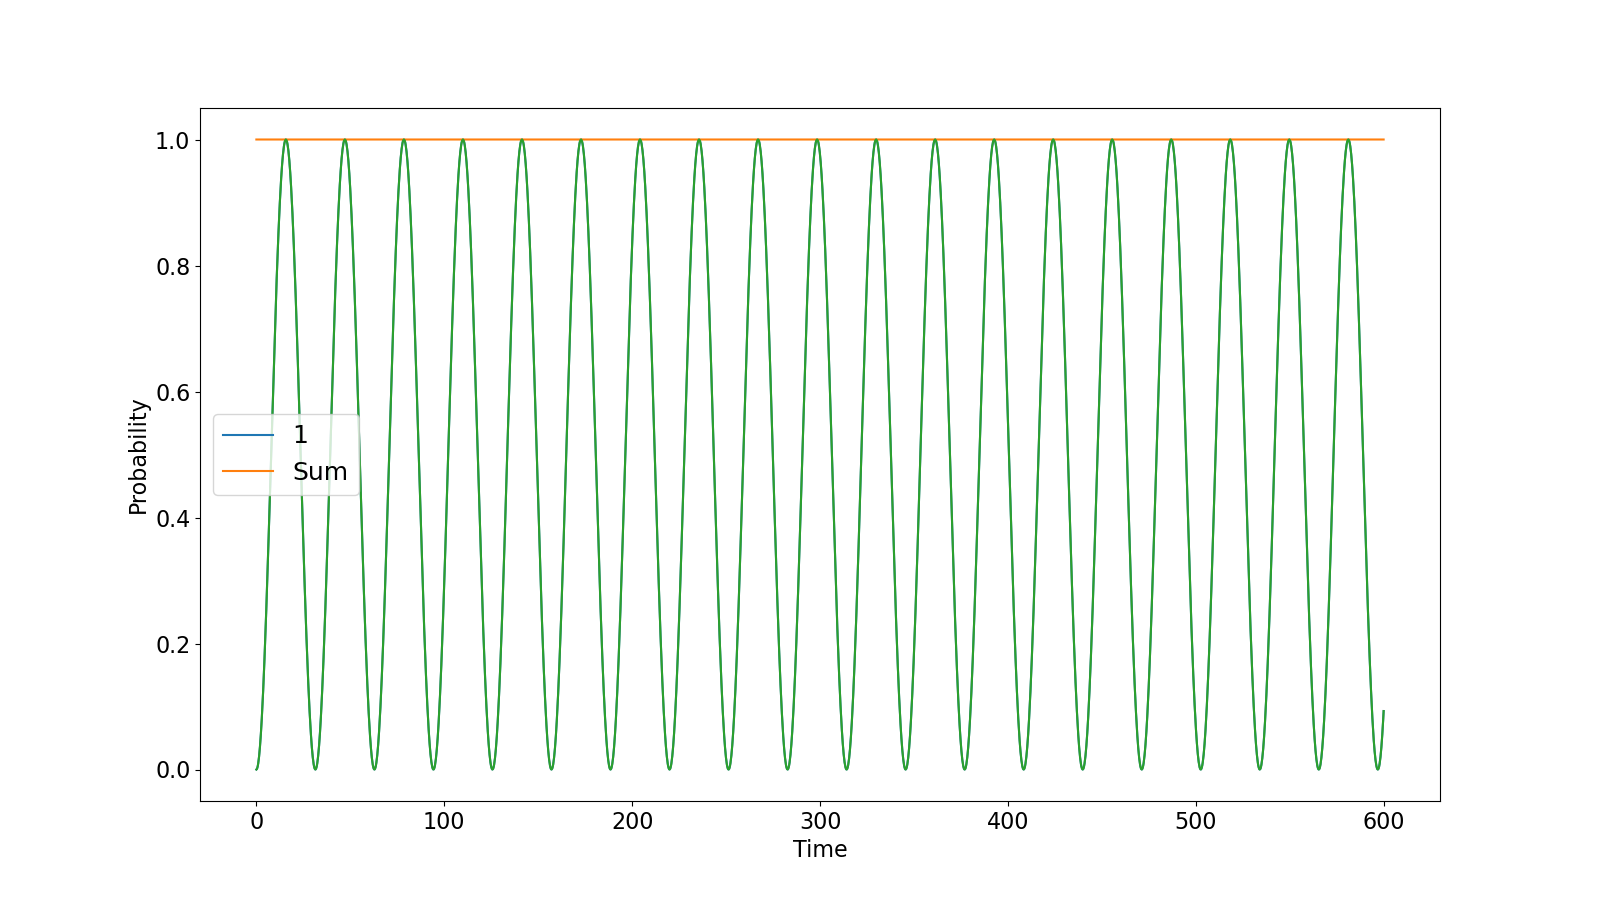

In [58]:
fig, ax = plt.subplots(figsize=(16,9))
probs = np.abs(result.states) ** 2
# ax.plot(result.times, probs[:,0], label="0")
ax.plot(result.times, probs[:,1].flatten(), label="1")
ax.plot(result.times, probs[:,1]+probs[:,0], label="Sum")
ax.plot(result.times, sineSqFit(result.times, *pop))
# ax.plot(result.times, sineSqFit(result.times, *[1, 0.1, 0, 0 ]))
ax.set_xlabel("Time")
ax.set_ylabel("Probability")
ax.legend()
plt.show()

In [60]:
print(pop)

[9.99999617e-01 9.99995939e-02 5.74311779e-08 3.82167805e-07]
